In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, AveragePooling2D, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization,RepeatVector, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Автокодировщик

основная модель MNIST-MNIST

In [14]:
def base_model_Autoencoder(level = 2, input_size=(28,28,1), kernel_list=[32, 64, 128, 256, 512]):
  #level = 2, число уровней сети (вообще должно соответствовать длине kernel_list или быть меньше)
  #input_size=(28, 28,1), - размер входной картинки
  #kernel_list=[32, 64, 128, 256, 512] - число ядер по слоям

  img_input = Input(input_size)

  x = Conv2D(kernel_list[0], (3, 3), padding = 'same', activation = 'relu')(img_input)
  x = BatchNormalization()(x)
  x = Conv2D(kernel_list[0], (3, 3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)
  #14x14
  for i in range(level-1):
    x = Conv2D(kernel_list[1+i], (3, 3), padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(kernel_list[1+i], (3, 3), padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

  x = Conv2D(kernel_list[level], (3, 3), padding = 'same', activation = 'relu')(x)  
  x1 = x
  print(x1.shape)
  # 7x7
  for i in range(level-1) :
    k = (level-1)-i  

    x = Conv2DTranspose( kernel_list[k], (2, 2), strides = (2, 2), padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
     
    x = Conv2D(kernel_list[k], (3, 3), padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(kernel_list[k], (3, 3), padding = 'same', activation = 'relu')(x)
    x = BatchNormalization()(x)
  # 14x14
  x = Conv2DTranspose(kernel_list[0], (2, 2), strides = (2, 2), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(kernel_list[0], (3, 3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(kernel_list[0], (3, 3), padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  # 28x28
  x = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(x)

  model = Model(img_input, x)
   
  modelviz0 = Model(img_input, x1)
  model.compile(optimizer = Adam(),
                  loss = 'mean_squared_error',
                  metrics = ['mse'])

  return model, modelviz0

Читаем MNIST

In [3]:
(xTrainMnist, yTrainMnist), (xTestMnist, yTestMnist) = mnist.load_data()

noice =0.5

xTrainMnist = xTrainMnist.astype('float32')/255

xTrainMnist = xTrainMnist.reshape(xTrainMnist.shape[0], 28, 28, 1)

yTrainMnist_pix = xTrainMnist.copy()
xTrainMnist += np.random.randn(xTrainMnist.shape[0],xTrainMnist.shape[1],xTrainMnist.shape[2],xTrainMnist.shape[3]) * noice

11501568/11490434 [==============================] - 0s 0us/step


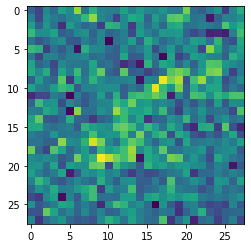

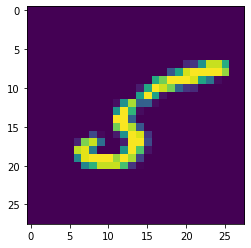

In [4]:
n_im = 11
plt.imshow(xTrainMnist[n_im,:,:,0])
plt.show()
plt.imshow(yTrainMnist_pix[n_im,:,:,0])
plt.show()

Собираем модель


In [15]:
modelAutoMnist, m0 = base_model_Autoencoder(level = 2, input_size = (28,28,1), kernel_list = [32,64,128,256])

(None, 7, 7, 128)


In [16]:
modelAutoMnist.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_27 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_28 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0   

In [17]:
# Обучение 10 эпох, пакетами по 100
#modelAutoMnist = denoiseAutoencoder()
hist=modelAutoMnist.fit(xTrainMnist[:10000], yTrainMnist_pix[:10000], epochs=10, batch_size=100, validation_split=0.2)

Epoch 1/10
80/80 [==============================] - 16s 64ms/step - loss: 0.0554 - mse: 0.0554 - val_loss: 0.0953 - val_mse: 0.0953
Epoch 2/10
80/80 [==============================] - 4s 55ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0694 - val_mse: 0.0694
Epoch 3/10
80/80 [==============================] - 4s 56ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 4/10
80/80 [==============================] - 4s 55ms/step - loss: 0.0118 - mse: 0.0118 - val_loss: 0.0181 - val_mse: 0.0181
Epoch 5/10
80/80 [==============================] - 5s 59ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0123 - val_mse: 0.0123
Epoch 6/10
80/80 [==============================] - 5s 59ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 7/10
80/80 [==============================] - 4s 55ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 8/10
80/80 [==============================] - 4s 55ms/step - loss: 0.0097 - 

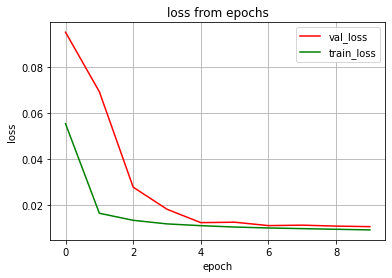

In [31]:
plt.plot(hist.history['val_loss'],'r',label='val_loss')
plt.plot(hist.history['loss'],'g',label='train_loss')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss from epochs')
plt.show()

Проверим на тестовых примерах:

In [33]:
# preprocessing 
noice =0.5
(_, _), (xTestMnist, yTestMnist) = mnist.load_data()

xTestMnist = xTestMnist.astype('float32')/255

xTestMnist = xTestMnist.reshape(xTestMnist.shape[0], 28, 28, 1)

yTestMnist_pix = xTestMnist.copy()
xTestMnist += np.random.randn(xTestMnist.shape[0],xTestMnist.shape[1],xTestMnist.shape[2],xTestMnist.shape[3]) * noice

Среди всех тестовых примеров достанем только примеры одного класса. Сейчас выбран класс "4"

Это не является необходимостью, но будем смотреть на некоторый средний объект в скрытом пространстве нашей модели. Поэтому интереснее смотреть на одноклассников - увидим некоторое упрощенно-идеальное описание объекта в картах признаков

In [34]:
mask = np.where(yTestMnist == 4)[0]

y_pred = modelAutoMnist.predict(xTestMnist[mask])

ff = m0.predict(xTestMnist[mask])
print(ff.shape)

ff = np.mean(ff, axis = 0)
print(ff.shape)



(982, 7, 7, 128)
(7, 7, 128)


In [35]:
mask[0]

4

Покажем наш пример и его распознавание, а также карты скрытого слоя

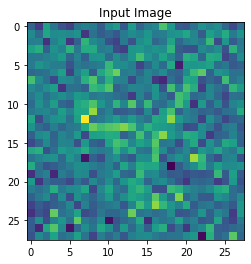

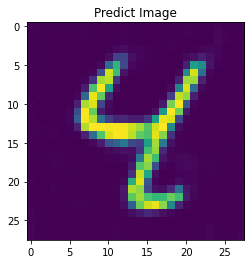

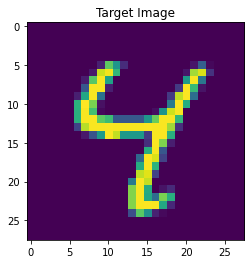

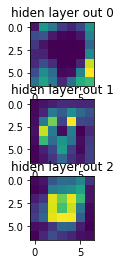

In [36]:
n = 1
plt.imshow(xTestMnist[mask[n],:,:,0])
plt.title('Input Image')
plt.show()
plt.imshow(y_pred[n,:,:,0])
plt.title('Predict Image')
plt.show()
plt.imshow(yTestMnist_pix[ mask[n],:,:,0])
plt.title('Target Image')
plt.show()

g1=ff[:,:,0]
plt.subplot(311)
plt.title('hiden layer out 0')
plt.imshow(g1)
g1=ff[:,:,1]
plt.subplot(312)
plt.title('hiden layer out 1')
plt.imshow(g1)
g1=ff[:,:,2]
plt.subplot(313)
plt.title('hiden layer out 2')
plt.imshow(g1)
plt.show()

# Визуализация слоев

средний объект - идеал??? 

batch_normalization_31
(10, 14, 14, 64)
(14, 14, 64)


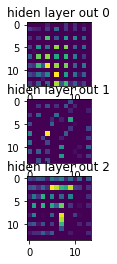

In [24]:
n = 13# номер уровня, на который смотрим
activ_model_layer = Model(inputs=modelAutoMnist.input, outputs = modelAutoMnist.layers[n].output)

print(modelAutoMnist.layers[n].name)

yf = activ_model_layer.predict(xTrainMnist[mask[:10]])


print(yf.shape)


#ff = np.mean(yf, axis=0) #средний выход слоя 
ff = yf[0,:,:,:] #средний выход слоя
print(ff.shape)

g1=ff[:,:,0]
plt.subplot(311)
plt.title('hiden layer out 0')
plt.imshow(g1)
g1=ff[:,:,2]
plt.subplot(312)
plt.title('hiden layer out 1')
plt.imshow(g1)
g1=ff[:,:,5]
plt.subplot(313)
plt.title('hiden layer out 2')
plt.imshow(g1)
plt.show()

Проверим фильтрацию для другого объекта FashionMNIST

In [28]:
(xT_fash, yT_fash), (xTest_f, yTest_f) = fashion_mnist.load_data()

noice = 0.5

xT_fash = xT_fash.astype('float32')/255

xT_fash = xT_fash.reshape(xT_fash.shape[0], 28, 28, 1)

xT_fash += np.random.randn(xT_fash.shape[0],xT_fash.shape[1],xT_fash.shape[2],xT_fash.shape[3]) * noice



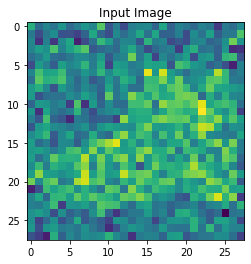

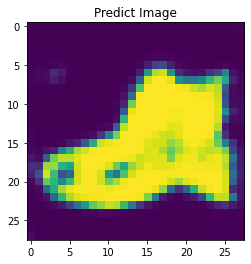

In [29]:
y_pred = modelAutoMnist.predict(xT_fash[:20])
N = 15
plt.imshow(xT_fash[N,:,:,0])
plt.title('Input Image')
plt.show()
plt.imshow(y_pred[N,:,:,0])
plt.title('Predict Image')
plt.show()


Резюме:
  - автоэнкодер работает как подавление шума
  - может подавить шум даже в другом типе данных